In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.applications import EfficientNetV2B1
from keras.applications.efficientnet_v2 import preprocess_input
from keras.layers import Dense , Flatten , MaxPooling2D, Conv2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation

# Define constants
img_height, img_width = 256, 256
batch_size = 32
max_samples = 2000  # Adjust this based on the largest class in your dataset

# Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

# Load the dataset with validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/eye-diseases-classification/dataset',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    verbose=True,
    labels="inferred",
    label_mode="int"
)

# Unbatch the dataset to process individual images
unbatched_data = train_dataset.unbatch()

# Augment and balance dataset by class
augmented_datasets = []

for class_index, class_name in enumerate(train_dataset.class_names):
    # Filter data for the specific class
    class_data = unbatched_data.filter(lambda x, y: y == class_index)
    
    # Apply augmentation and repeat data for balancing
    augmented_class = class_data.map(lambda x, y: (data_augmentation(x), y)).repeat().take(max_samples)
    
    # Add to the list of augmented datasets
    augmented_datasets.append(augmented_class)

# Combine all the augmented datasets into a balanced dataset
balanced_data = tf.data.Dataset.sample_from_datasets(augmented_datasets)

# Batch and prefetch the data for efficient training
balanced_data = (
    balanced_data
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Verify the dataset
for images, labels in balanced_data.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")


Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Images shape: (32, 256, 256, 3)
Labels shape: (32,)


In [4]:
import numpy as np
from collections import Counter

# Initialize a counter to track class occurrences
class_counter = Counter()

# Iterate over the balanced dataset and count occurrences of each class
for images, labels in balanced_data:
    class_counter.update(labels.numpy())  # Convert Tensor to NumPy array and update counter

# Print the count of samples for each class
for class_index, count in class_counter.items():
    class_name = train_dataset.class_names[class_index]
    print(f"Class: {class_name}, Count: {count}")

Class: cataract, Count: 2000
Class: normal, Count: 2000
Class: diabetic_retinopathy, Count: 2000
Class: glaucoma, Count: 2000


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/eye-diseases-classification/dataset' ,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    verbose=True,
    labels="inferred",
    label_mode="int"
)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [6]:
train_dataset.class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [7]:
import numpy as np
from collections import Counter

# Extract the labels from the dataset
labels = []
for _, batch_labels in validation_dataset:
    labels.extend(batch_labels.numpy())  # Convert Tensor to NumPy array

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names
class_names = validation_dataset.class_names

# Print the count for each class
for label, count in label_counts.items():
    print(f"Class '{class_names[label]}': {count} samples")


Class 'glaucoma': 201 samples
Class 'diabetic_retinopathy': 217 samples
Class 'normal': 221 samples
Class 'cataract': 204 samples


In [8]:
def preprocess(image,label):

  image=preprocess_input(image)

  return image,label

In [9]:
balanced_data = balanced_data.map(preprocess)

In [10]:
validation_dataset = validation_dataset.map(preprocess)

In [11]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [12]:
transmodel = EfficientNetV2B1(

    include_top=False,

    weights="imagenet",

    input_shape=(256,256,3)

)

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
transmodel.trainable=True

set_trainable=False

for layer in transmodel.layers:

  if layer.name == 'block5_conv1':

    set_trainable=True

  if set_trainable:

    layer.trainable=True

  else:

    layer.trainable =  False

In [14]:
model = Sequential()

In [15]:
from tensorflow.keras import regularizers

model.add(transmodel)

# Add Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))  # Adjust the units to match your classes

# Explicitly build the model
model.build((None, 256, 256, 3))


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)       │ (None, 8, 8, 1280)          │       6,931,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 81920)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,485,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,428,376 (66.48 MB)

 Trainable params: 10,496,804 (40.04 MB)

 Non-trainable params: 6,931,572 (26.44 MB)

In [17]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [19]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [20]:
fit_hist = model.fit(balanced_data,epochs=30, batch_size=32 ,validation_data=validation_dataset, callbacks=[callback, reduce_lr])

Epoch 1/30
    250/Unknown 152s 474ms/step - accuracy: 0.5470 - loss: 3.9030

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 539ms/step - accuracy: 0.5474 - loss: 3.8990 - val_accuracy: 0.8553 - val_loss: 1.6437 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 483ms/step - accuracy: 0.7623 - loss: 1.7977 - val_accuracy: 0.8470 - val_loss: 1.5889 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 482ms/step - accuracy: 0.7738 - loss: 1.9395 - val_accuracy: 0.8244 - val_loss: 1.6839 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 486ms/step - accuracy: 0.7717 - loss: 1.7338 - val_accuracy: 0.7995 - val_loss: 1.6220 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 483ms/step - accuracy: 0.7728 - loss: 1.6157 - val_accuracy: 0.8683 - val_loss: 1.4308 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 481ms/step - accuracy: 0.7733 - loss: 1.6180 - val_accuracy: 0.8387 - val_loss: 1.8036 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 481ms/step - accuracy: 0.7827 

In [21]:
# Save the model to a file
model.save('path_to_save_model/fmodel.h5')

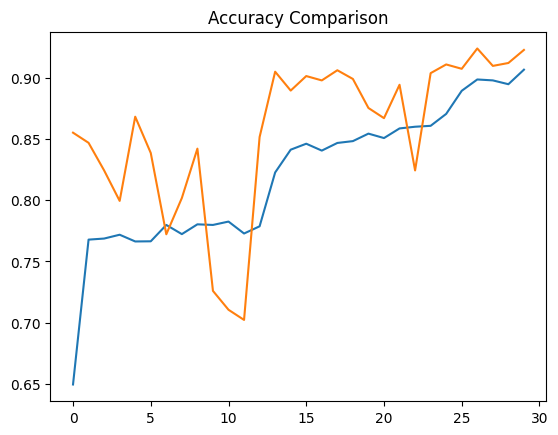

In [22]:
plt.plot(fit_hist.history['accuracy'])
plt.plot(fit_hist.history['val_accuracy'])
plt.title('Accuracy Comparison')
plt.show()

In [23]:
import pickle

In [24]:
with open("accuracy.pkl", 'wb') as file:
    pickle.dump(fit_hist.history['accuracy'], file)
with open("val_accuracy.pkl", 'wb') as file:
    pickle.dump(fit_hist.history['val_accuracy'], file)

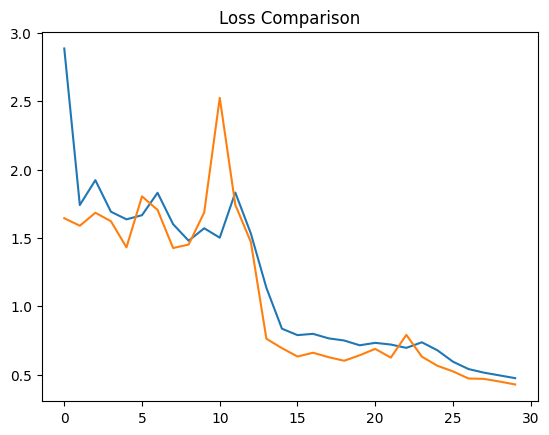

In [25]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.title('Loss Comparison')
plt.show()

In [26]:
import pickle

with open("loss.pkl", 'wb') as file:
    pickle.dump(fit_hist.history['loss'], file)
with open("val_loss.pkl", 'wb') as file:
    pickle.dump(fit_hist.history['val_loss'], file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

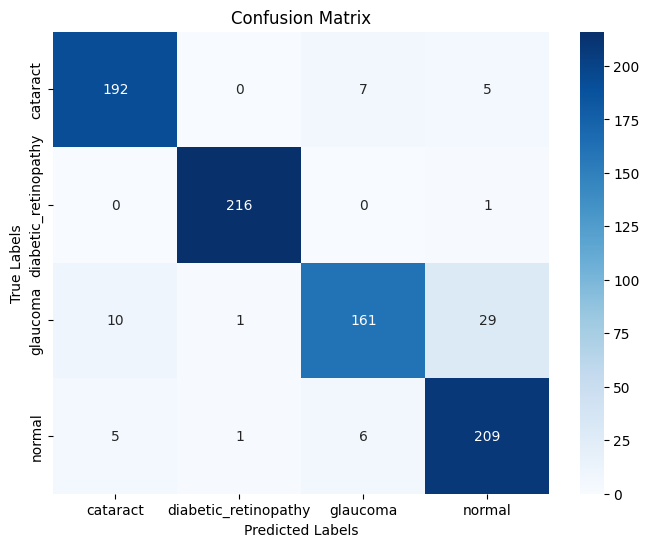

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    
    y_pred_batch = np.argmax(predictions, axis=-1)  # Convert to class indices
    
    y_true.extend(labels.numpy())  # Collect true labels
    y_pred.extend(y_pred_batch)  # Collect predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")

if len(y_true) == len(y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'], yticklabels=['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    # Save the plot to a file (e.g., 'roc_curve.png')
    plt.savefig('confusion_matrix.png', format='png')
    plt.close()  # Close the plot to free up memory
else:
    print("Mismatch in number of true labels and predicted labels.")

In [28]:

with open('confusion.pkl', 'wb') as file:
    pickle.dump(cm, file)

In [29]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    y_pred_batch = np.argmax(predictions, axis=-1)
    y_true.extend(labels.numpy())
    y_pred.extend(y_pred_batch)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

if len(y_true) == len(y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']))
else:
    print("Mismatch in number of true labels and predicted labels.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [31]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


In [32]:
import pickle

with open('classification.pkl', 'wb') as file:
    pickle.dump(report_df, file)
print("Classification report saved as 'classification.pkl'")


Classification report saved as 'classification.pkl'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

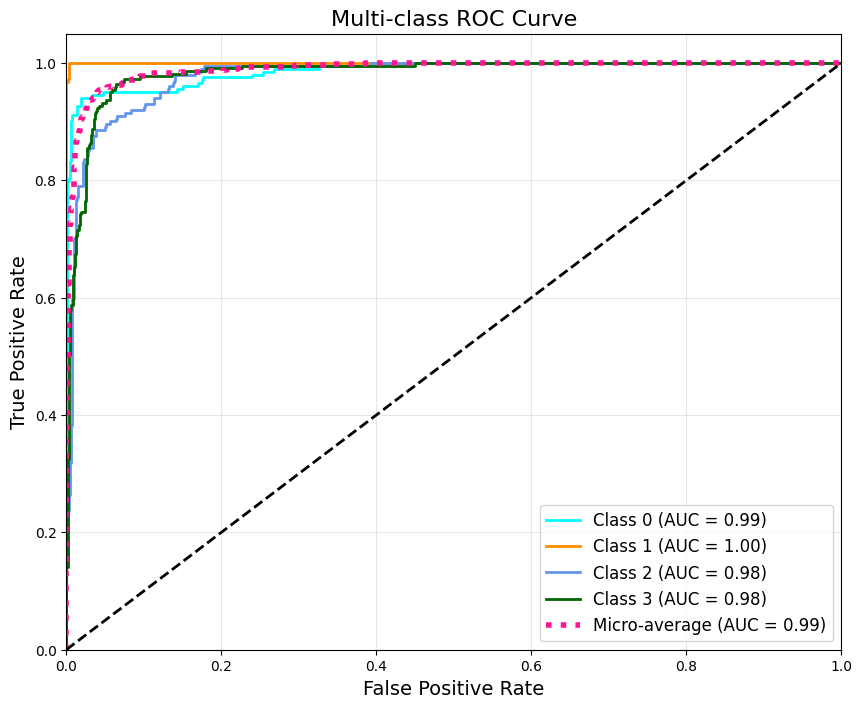

In [33]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_true = []
y_pred_prob = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    
    y_true.extend(labels.numpy())  # Collect true labels
    y_pred_prob.extend(predictions)  # Collect predicted probabilities

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_prob: {len(y_pred_prob)}")

if len(y_true) == len(y_pred_prob):
    classes = np.unique(y_true)
    y_true_binarized = label_binarize(y_true, classes=classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
    for i, color in enumerate(colors[:len(classes)]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Multi-class ROC Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()
    # Save the plot to a file (e.g., 'roc_curve.png')
    plt.savefig('roc_curve.png', format='png')
    plt.close()  # Close the plot to free up memory
else:
    print("Mismatch in number of true labels and predicted labels.")

In [34]:
with open('fpr["micro"].pkl', 'wb') as file:
    pickle.dump(fpr["micro"], file)
with open('tpr["micro"].pkl', 'wb') as file:
    pickle.dump(tpr["micro"], file)
with open('-i.pkl', 'wb') as file:
    pickle.dump(_, file)
with open('roc_auc.pkl', 'wb') as file:
    pickle.dump(roc_auc["micro"], file)

In [35]:
import os
print("Files in directory:", os.listdir('/kaggle/working'))


Files in directory: ['val_accuracy.pkl', 'roc_auc.pkl', '-i.pkl', 'accuracy.pkl', 'confusion.pkl', 'classification.pkl', 'val_loss.pkl', '.virtual_documents', 'tpr["micro"].pkl', 'loss.pkl', 'fpr["micro"].pkl', 'confusion_matrix.png', 'path_to_save_model', 'roc_curve.png']


In [43]:
eye_classification_testing_path = kagglehub.dataset_download('muhammadhamzanawaz/eye-classification-testing')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: cataract


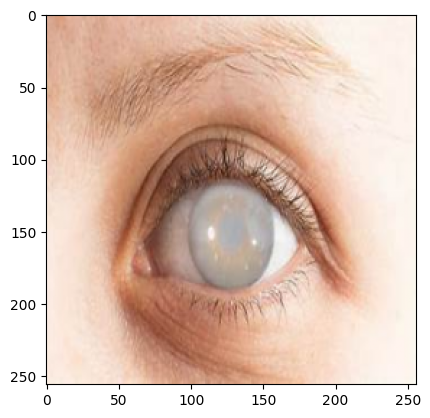

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
test_img3 = cv2.imread('/kaggle/input/eye-classification-testing/cataract.png')

# Convert BGR to RGB
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)

# Resize to model input size
test_img3 = cv2.resize(test_img3, (256, 256))

# Normalize (assuming model was trained with normalization)
test_img3 = test_img3 / 255.0  # Normalize pixel values

# Reshape to match model input
test_input3 = test_img3.reshape((1, 256, 256, 3))

# Make prediction
pred3 = model.predict(test_input3)

# Get predicted class index
prediction3 = np.argmax(pred3, axis=1)

# Convert index to class label
predicted_label = classname[prediction3[0]]

print(f"Predicted class: {predicted_label}")

plt.imshow(test_img3)  # Display the image
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: Diabetic


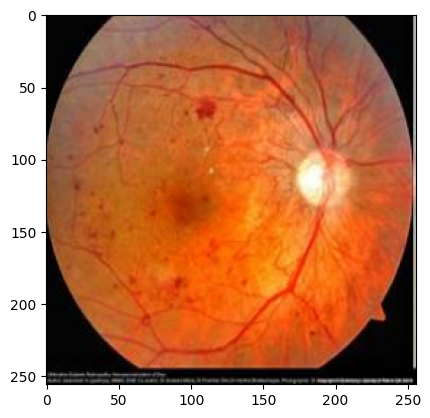

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
test_img3 = cv2.imread('/kaggle/input/eye-classification-testing/diabetic_retinopathy.png')

# Convert BGR to RGB
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)

# Resize to model input size
test_img3 = cv2.resize(test_img3, (256, 256))

# Normalize (assuming model was trained with normalization)
test_img3 = test_img3 / 255.0  # Normalize pixel values

# Reshape to match model input
test_input3 = test_img3.reshape((1, 256, 256, 3))

# Make prediction
pred3 = model.predict(test_input3)

# Get predicted class index
prediction3 = np.argmax(pred3, axis=1)

# Convert index to class label
predicted_label = classname[prediction3[0]]

print(f"Predicted class: {predicted_label}")

plt.imshow(test_img3)  # Display the image
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: glaucoma


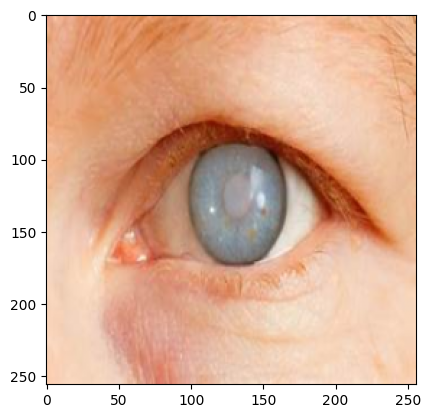

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
test_img3 = cv2.imread('/kaggle/input/eye-classification-testing/glaucoma.png')

# Convert BGR to RGB
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)

# Resize to model input size
test_img3 = cv2.resize(test_img3, (256, 256))

# Normalize (assuming model was trained with normalization)
test_img3 = test_img3 / 255.0  # Normalize pixel values

# Reshape to match model input
test_input3 = test_img3.reshape((1, 256, 256, 3))

# Make prediction
pred3 = model.predict(test_input3)

# Get predicted class index
prediction3 = np.argmax(pred3, axis=1)

# Convert index to class label
predicted_label = classname[prediction3[0]]

print(f"Predicted class: {predicted_label}")

plt.imshow(test_img3)  # Display the image
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: normal


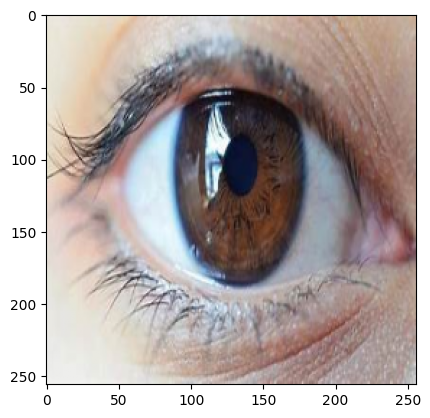

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
test_img3 = cv2.imread('/kaggle/input/eye-classification-testing/normal.png')

# Convert BGR to RGB
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB)

# Resize to model input size
test_img3 = cv2.resize(test_img3, (256, 256))

# Normalize (assuming model was trained with normalization)
test_img3 = test_img3 / 255.0  # Normalize pixel values

# Reshape to match model input
test_input3 = test_img3.reshape((1, 256, 256, 3))

# Make prediction
pred3 = model.predict(test_input3)

# Get predicted class index
prediction3 = np.argmax(pred3, axis=1)

# Convert index to class label
predicted_label = classname[prediction3[0]]

print(f"Predicted class: {predicted_label}")

plt.imshow(test_img3)  # Display the image
plt.show()
